In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.3 MB/s eta 0:00:00


In [4]:
pip install salib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.1/780.1 kB 11.4 MB/s eta 0:00:00


Training MOGP on N=45 (Live)...
Training Complete.


/tmp/ipython-input-3729560292.py:144: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


Saved 'Sobol_Sensitivity_MOGP.pdf'


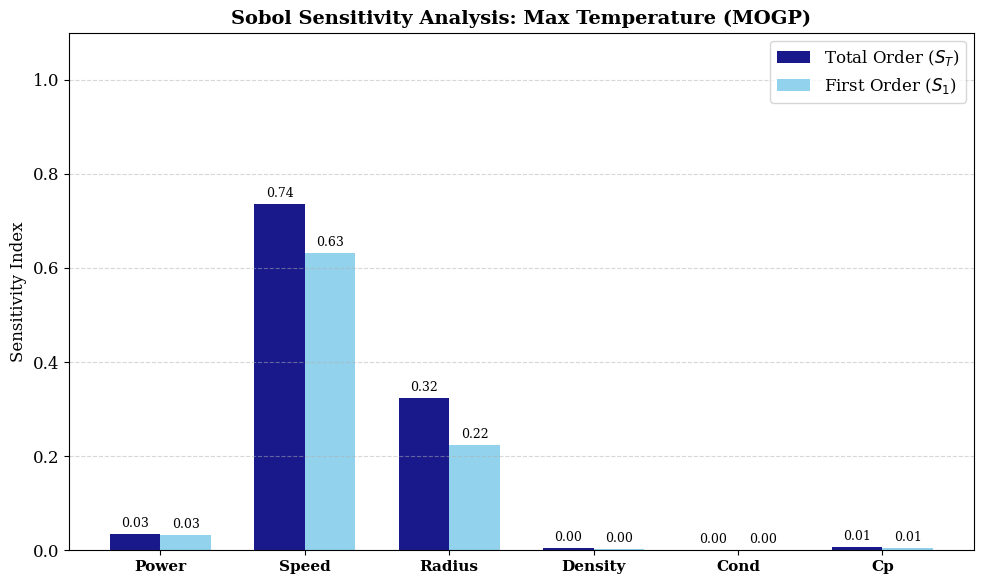

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import io
import joblib
from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# --- 1. DATA INGESTION (N=45) ---
csv_content = """Run,Material,Power_W/mm2,Speed_mm/s,Radius_mm,Y1_Max_Prin_Stress (MPa),Y2_Max_Von_Mises,Y3_Deformation mm,Max Temp,Heat flux
1,CoCrFeNiMn ,137.27,5.31,1.44,355.95,1360.2,0.0172,255.24,0.4193
2,CoCrFeNiMn ,260.59,39.51,1.11,43.22,215.36,0.0027,58.48,0.0933
3,CoCrFeNiMn ,183.35,21.1,1.22,70.385,339.24,0.0042,79.584,0.1412
4,CoCrFeNiMn ,56.31,32.79,0.89,7.3,36.37,0.0005,28.17,0.0158
5,CoCrFeNiMn ,86.3,22.69,1.06,22.986,112.5,0.0014,41.09,0.0474
6,CoCrFeNiMn ,217.8,33.32,1.4,67.52,336.46,0.0042,78.97,0.1449
7,CoCrFeNiMn ,289.23,16.03,0.92,86.55,403.25,0.005,90.65,0.1651
8,CoCrFeNiMn ,169.14,49.17,1.27,29.557,147.42,0.0018,46.94,0.0649
9,CoCrFeNiMn ,147.07,16.71,0.94,43.89,204.7,0.0025,56.82,0.0838
10,CoCrFeNiMn ,282.05,28.76,1.29,0,0,0,22,0
11,AlCoCrFeNi,137.27,5.31,1.44,405.6,1982.7,0.031,254.83,0.4175
12,AlCoCrFeNi,260.59,39.51,1.11,57.721,310.92,0.005,58.41,0.093
13,AlCoCrFeNi,183.35,21.1,1.22,90.92,490.46,0.0078,79.47,0.1407
14,AlCoCrFeNi,56.31,32.79,0.89,9.65,51.98,0.0008,28.09,0.0156
15,AlCoCrFeNi,86.3,22.69,1.06,30.148,162.61,0.0026,41.06,0.0472
16,AlCoCrFeNi,217.8,33.32,1.4,90.2,485.68,0.0078,78.86,0.1444
17,AlCoCrFeNi,289.23,16.03,0.92,108.03,583.96,0.0092,90.52,0.1645
18,AlCoCrFeNi,169.14,49.17,1.27,39.49,212.61,0.0034,46.9,0.0646
19,AlCoCrFeNi,147.07,16.71,0.94,58.84,296.28,0.0047,56.75,0.0835
20,AlCoCrFeNi,282.05,28.76,1.29,0,0,0,22,0
21,FeCrNiTiAl,137.27,5.31,1.44,404.89,1980.9,0.0311,254.88,0.4171
22,FeCrNiTiAl,260.59,39.51,1.11,54.462,310.64,0.005,58.42,0.093
23,FeCrNiTiAl,183.35,21.1,1.22,58.788,490.1,0.0078,79.48,0.1406
24,FeCrNiTiAl,56.31,32.79,0.89,9.1938,52.51,0.0008,28.16,0.0158
25,FeCrNiTiAl,86.3,22.69,1.06,28.446,162.46,0.0026,41.06,0.0472
26,FeCrNiTiAl,217.8,33.32,1.4,85.11,485.24,0.0078,78.87,0.1444
27,FeCrNiTiAl,289.23,16.03,0.92,101.94,583.43,0.0093,90.532,0.1644
28,FeCrNiTiAl,169.14,49.17,1.27,37.258,212.41,0.0034,46.9,0.0646
29,FeCrNiTiAl,147.07,16.71,0.94,51.748,296.01,0.0047,56.76,0.0834
30,FeCrNiTiAl,282.05,28.76,1.29,0,0,0,22,0
31,NbSiTaTiZr,137.27,5.31,1.44,402.62,1985.1,0.0309,255.76,0.4206
32,NbSiTaTiZr,260.59,39.51,1.11,53.92,311.33,0.0049,58.57,0.0936
33,NbSiTaTiZr,183.35,21.1,1.22,70.41,407.24,0.0065,69.87,0.1175
34,NbSiTaTiZr,56.31,32.79,0.89,9.01,52.05,0.0008,28.12,0.0157
35,NbSiTaTiZr,86.3,22.69,1.06,24.83,134.91,0.0022,37.77,0.0326
36,NbSiTaTiZr,217.8,33.32,1.4,84.27,486.33,0.0077,79.1,0.1453
37,NbSiTaTiZr,289.23,16.03,0.92,100.84,584.51,0.0092,90.78,0.1654
38,NbSiTaTiZr,169.14,49.17,1.27,36.89,212.89,0.0034,47,0.065
39,NbSiTaTiZr,147.07,16.71,0.94,51.19,296.55,0.0047,56.88,0.0839
40,NbSiTaTiZr,282.05,28.76,1.29,0,0,0,22,0
41,HfNbTiZr,137.27,5.31,1.44,404.99,1990.7,0.0311,256.07,0.4218
42,HfNbTiZr,260.59,39.51,1.11,55.88,312.25,0.005,58.62,0.0938
43,HfNbTiZr,183.35,21.1,1.22,87.98,492.33,0.0078,79.77,0.1418
44,HfNbTiZr,56.31,32.79,0.89,9.34,52.2,0.0008,28.12,0.0157
45,HfNbTiZr,86.3,22.69,1.06,29.182,163.3,0.0026,41.165,0.0476
46,HfNbTiZr,217.8,33.32,1.4,87.193,487.08,0.0078,79.1,0.1455
47,HfNbTiZr,289.23,16.03,0.92,104.53,586.2,0.0093,90.88,0.1658
48,HfNbTiZr,169.14,49.17,1.27,38.227,213.52,0.0034,47.04,0.0652
49,HfNbTiZr,147.07,16.71,0.94,53.06,297.41,0.0047,56.93,0.0841
50,HfNbTiZr,282.05,28.76,1.29,0,0,0,22,0
"""
df = pd.read_csv(io.StringIO(csv_content))
df['Material'] = df['Material'].str.strip()
df_clean = df[(df['Y2_Max_Von_Mises'] > 1e-6) & (df['Heat flux'] > 1e-6)].copy()

# Physics Embedding
material_props = {
    'CoCrFeNiMn': [8250, 12.5, 425],
    'AlCoCrFeNi': [8000, 15.0, 445],
    'FeCrNiTiAl': [8100, 15.0, 435],
    'NbSiTaTiZr': [8350, 10.0, 405],
    'HfNbTiZr':   [8450, 8.5,  395]
}
props_df = pd.DataFrame(df_clean['Material'].map(material_props).tolist(),
                        index=df_clean.index, columns=['Density', 'Conductivity', 'Cp'])
process_params = ['Power_W/mm2', 'Speed_mm/s', 'Radius_mm']
X = pd.concat([df_clean[process_params], props_df], axis=1)
y = df_clean['Max Temp'] # Analysis Target

# --- 2. DEFINE MOGP (Source: digital_twin_files.py) ---
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)
            ),
            num_tasks=5, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# --- 3. TRAIN MOGP (Robust Live Fallback) ---
# Prepare Tensors
X_scaler = MinMaxScaler().fit(X)
y_scaler = StandardScaler().fit(df_clean[['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']])

X_sc = X_scaler.transform(X)
y_sc = y_scaler.transform(df_clean[['Y1_Max_Prin_Stress (MPa)', 'Y2_Max_Von_Mises', 'Y3_Deformation mm', 'Max Temp', 'Heat flux']])

train_x = torch.tensor(X_sc, dtype=torch.float32)
train_y = torch.tensor(y_sc, dtype=torch.float32)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
model = MOGP_Surrogate(train_x, train_y, likelihood)

# Train on N=45
model.train(); likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

print("Training MOGP on N=45 (Live)...")
for i in range(50):
    optimizer.zero_grad()
    out = model(train_x)
    loss = -mll(out, train_y)
    loss.backward()
    optimizer.step()
print("Training Complete.")

# --- 4. SOBOL ANALYSIS (Live Calculation) ---
model.eval(); likelihood.eval()

# A. Define Problem (Source: digital_twin_files.py)
problem = {
    'num_vars': 6,
    'names': ['Power', 'Speed', 'Radius', 'Density', 'Cond', 'Cp'],
    'bounds': [
        [50, 300], [5, 50], [0.8, 1.5], # Process
        [8000, 8450], [8.0, 16.0], [395, 445] # Physics
    ]
}

# B. Sample (Saltelli)
# Generate samples (N=1024 * (2D+2) = ~14k samples)
param_values = saltelli.sample(problem, 1024)
X_sobol = torch.tensor(X_scaler.transform(pd.DataFrame(param_values, columns=X.columns)), dtype=torch.float32)

# C. Predict (Batched MOGP Inference)
Y_sobol = []
batch_size = 500
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(0, len(X_sobol), batch_size):
        batch = X_sobol[i:i+batch_size]
        dist = likelihood(model(batch))
        # Extract Max Temp (Index 3 in y_scaler)
        preds = dist.mean[:, 3].numpy()
        # Unscale
        preds_real = (preds * y_scaler.scale_[3]) + y_scaler.mean_[3]
        Y_sobol.append(preds_real)

Y_sobol_flat = np.concatenate(Y_sobol)

# D. Analyze
Si = sobol.analyze(problem, Y_sobol_flat)

# --- 5. PLOTTING ---
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(10, 6))

indices = np.arange(len(problem['names']))
width = 0.35

# Plot First Order (S1) and Total Order (ST)
rects1 = ax.bar(indices - width/2, Si['ST'], width, label='Total Order ($S_T$)', color='navy', alpha=0.9)
rects2 = ax.bar(indices + width/2, Si['S1'], width, label='First Order ($S_1$)', color='skyblue', alpha=0.9)

ax.set_ylabel('Sensitivity Index')
ax.set_title('Sobol Sensitivity Analysis: Max Temperature (MOGP)', fontsize=14, fontweight='bold')
ax.set_xticks(indices)
ax.set_xticklabels(problem['names'], fontsize=11, fontweight='bold')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('Sobol_Sensitivity_MOGP.pdf', format='pdf', dpi=300)
print("Saved 'Sobol_Sensitivity_MOGP.pdf'")
plt.show()